In [1]:
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
file_path = "data/german.data"

df = pd.read_csv(file_path, sep=" ", header=None)

print(df.head())

    0   1    2    3     4    5    6   7    8     9   ...    11  12    13  \
0  A11   6  A34  A43  1169  A65  A75   4  A93  A101  ...  A121  67  A143   
1  A12  48  A32  A43  5951  A61  A73   2  A92  A101  ...  A121  22  A143   
2  A14  12  A34  A46  2096  A61  A74   2  A93  A101  ...  A121  49  A143   
3  A11  42  A32  A42  7882  A61  A74   2  A93  A103  ...  A122  45  A143   
4  A11  24  A33  A40  4870  A61  A73   3  A93  A101  ...  A124  53  A143   

     14 15    16 17    18    19 20  
0  A152  2  A173  1  A192  A201  1  
1  A152  1  A173  1  A191  A201  2  
2  A152  1  A172  2  A191  A201  1  
3  A153  1  A173  2  A191  A201  1  
4  A153  2  A173  2  A191  A201  2  

[5 rows x 21 columns]


In [3]:
column_names = [
    "Checking_Acc_Status", "Duration (in months)", "Credit_History", "Purpose",
    "Credit_Amount", "Savings_Acc", "Employment", "Installment_Rate",
    "Personal_Status", "Other_Debtors", "Residence_Since", "Property",
    "Age", "Other_Installment", "Housing", "Existing_Credits",
    "Job", "Num_People_Maintained", "Telephone", "Foreign_Worker", "Credit Standing"
]
# Assign column names
df.columns = column_names

mappings = {
    "Checking_Acc_Status": {
        "A11": "< 0 DM",
        "A12": "0-200 DM",
        "A13": ">= 200 DM or Salary Assigned",
        "A14": "No Checking Account"
    },
    "Credit_History": {
        "A30": "No Credit Taken / All Paid",
        "A31": "All Paid (Same Bank)",
        "A32": "All Paid (Other Banks)",
        "A33": "Past Delays in Payment",
        "A34": "Critical Account / Other Existing Credits"
    },
    "Purpose": {
        "A40": "New Car",
        "A41": "Used Car",
        "A42": "Furniture/Equipment",
        "A43": "Radio/TV",
        "A44": "Domestic Appliances",
        "A45": "Repairs",
        "A46": "Education",
        "A47": "Vacation",
        "A48": "Retraining",
        "A49": "Business",
        "A410": "Others"
    },
    "Savings_Acc": {
        "A61": "< 100 DM",
        "A62": "100-500 DM",
        "A63": "500-1000 DM",
        "A64": ">= 1000 DM",
        "A65": "No Savings Account"
    },
    "Employment": {
        "A71": "Unemployed",
        "A72": "< 1 Year",
        "A73": "1-4 Years",
        "A74": "4-7 Years",
        "A75": ">= 7 Years"
    },
    "Personal_Status": {
        "A91": "Male: Divorced/Separated",
        "A92": "Female: Divorced/Separated/Married",
        "A93": "Male: Single",
        "A94": "Male: Married/Widowed",
        "A95": "Female: Single"
    },
    "Other_Debtors": {
        "A101": "None",
        "A102": "Co-applicant",
        "A103": "Guarantor"
    },
    "Property": {
        "A121": "Real Estate",
        "A122": "Building Society Savings / Life Insurance",
        "A123": "Car or Other Property",
        "A124": "No Property"
    },
    "Other_Installment": {
        "A141": "Bank",
        "A142": "Stores",
        "A143": "None"
    },
    "Housing": {
        "A151": "Rent",
        "A152": "Own",
        "A153": "For Free"
    },
    "Job": {
        "A171": "Unemployed / Unskilled (Non-Resident)",
        "A172": "Unskilled (Resident)",
        "A173": "Skilled Employee / Official",
        "A174": "Management / Self-Employed / Highly Qualified"
    },
    "Telephone": {
        "A191": "No Telephone",
        "A192": "Yes, Registered"
    },
    "Foreign_Worker": {
        "A201": "Yes",
        "A202": "No"
    }
}

for col, mapping in mappings.items():
    df[col] = df[col].map(mapping)

# Print updated DataFrame
print(df.head())

   Checking_Acc_Status  Duration (in months)  \
0               < 0 DM                     6   
1             0-200 DM                    48   
2  No Checking Account                    12   
3               < 0 DM                    42   
4               < 0 DM                    24   

                              Credit_History              Purpose  \
0  Critical Account / Other Existing Credits             Radio/TV   
1                     All Paid (Other Banks)             Radio/TV   
2  Critical Account / Other Existing Credits            Education   
3                     All Paid (Other Banks)  Furniture/Equipment   
4                     Past Delays in Payment              New Car   

   Credit_Amount         Savings_Acc  Employment  Installment_Rate  \
0           1169  No Savings Account  >= 7 Years                 4   
1           5951            < 100 DM   1-4 Years                 2   
2           2096            < 100 DM   4-7 Years                 2   
3           7882

/var/folders/nk/xk4mj8ts0ps645l4yh1nyfmh0000gp/T/ipykernel_83965/2026491584.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index,


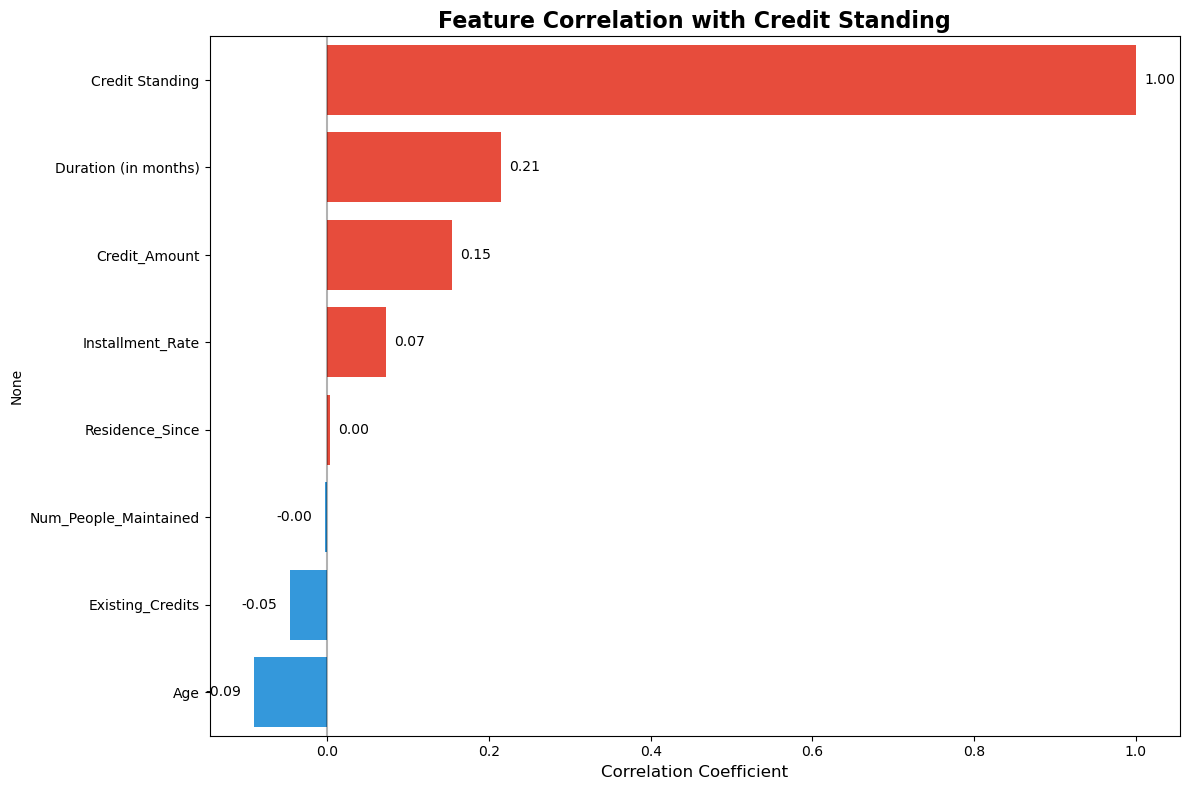

In [4]:
# 1. Correlation analysis - Place this BEFORE one-hot encoding
# Select numerical columns for correlation analysis
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Calculate correlation with target
correlation_with_target = df[numerical_cols].corrwith(df['Credit Standing']).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = sns.barplot(x=correlation_with_target.values, y=correlation_with_target.index, 
                  palette=sns.color_palette("RdBu_r", len(correlation_with_target)))

plt.title('Feature Correlation with Credit Standing', fontsize=16, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

# Color bars based on correlation value
for i, bar in enumerate(bars.patches):
    if correlation_with_target.values[i] > 0:
        bar.set_facecolor('#e74c3c')  # Red for positive correlation
    else:
        bar.set_facecolor('#3498db')  # Blue for negative correlation

# Add correlation values as text
for i, v in enumerate(correlation_with_target.values):
    plt.text(v + 0.01 if v >= 0 else v - 0.06, i, f'{v:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [5]:
# Convert categorical data to numerical format using one-hot encoding
df = pd.get_dummies(df, drop_first=True).astype(int)

# Map the 'Credit Standing' column from 1 (good) and 2 (bad) to 0 (good) and 1 (bad)
df['Credit Standing'] = df['Credit Standing'].map({1: 0, 2: 1})

# Ensure all categorical columns are encoded as 0s and 1s
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category').cat.codes

# Print updated DataFrame
print(df.head())

   Duration (in months)  Credit_Amount  Installment_Rate  Residence_Since  \
0                     6           1169                 4                4   
1                    48           5951                 2                2   
2                    12           2096                 2                3   
3                    42           7882                 2                4   
4                    24           4870                 3                4   

   Age  Existing_Credits  Num_People_Maintained  Credit Standing  \
0   67                 2                      1                0   
1   22                 1                      1                1   
2   49                 1                      2                0   
3   45                 1                      2                0   
4   53                 2                      2                1   

   Checking_Acc_Status_< 0 DM  \
0                           1   
1                           0   
2                           0

In [6]:

# Set a more appealing visual style
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.edgecolor'] = '#333333'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333333'
plt.rcParams['ytick.color'] = '#333333'

# Custom color palette
custom_palette = ['#3498db', '#e74c3c']
custom_cmap = sns.diverging_palette(220, 10, as_cmap=True)



/var/folders/nk/xk4mj8ts0ps645l4yh1nyfmh0000gp/T/ipykernel_83965/111392532.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=custom_palette)


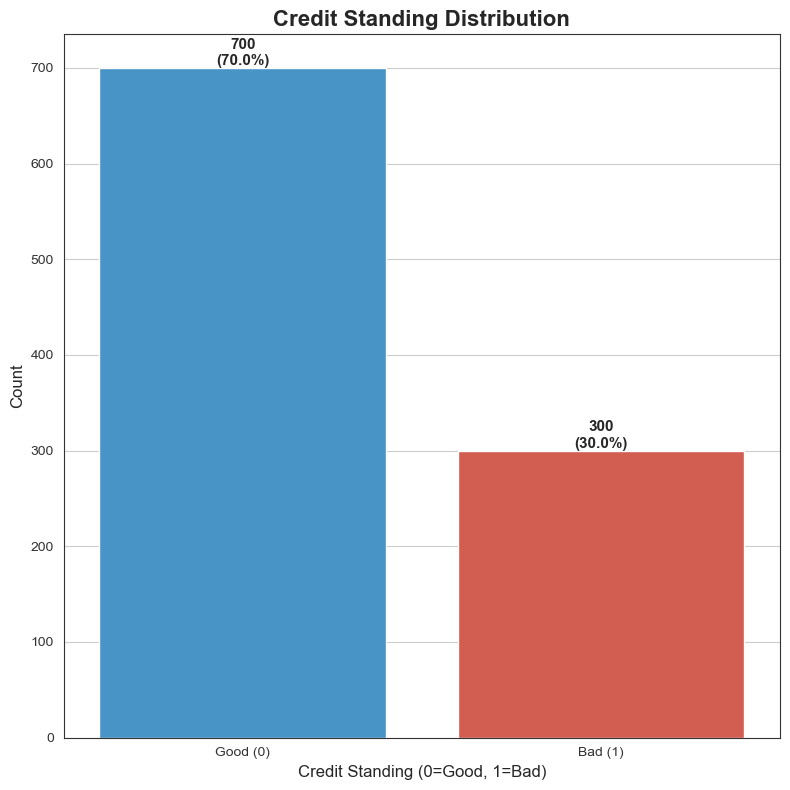

Good credits: 700 (70.00%)
Bad credits: 300 (30.00%)


In [7]:
# 1. Check class distribution in the target variable
plt.figure(figsize=(8, 8))
target_counts = df['Credit Standing'].value_counts()
ax = sns.barplot(x=target_counts.index, y=target_counts.values, palette=custom_palette)
plt.title('Credit Standing Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Credit Standing (0=Good, 1=Bad)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Good (0)', 'Bad (1)'], fontsize=10)

# Add percentage labels
total = len(df)
for i, p in enumerate(ax.patches):
    percentage = 100 * p.get_height() / total
    ax.annotate(f'{int(p.get_height())}\n({percentage:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Good credits: {target_counts[0]} ({target_counts[0]/total*100:.2f}%)")
print(f"Bad credits: {target_counts[1]} ({target_counts[1]/total*100:.2f}%)")

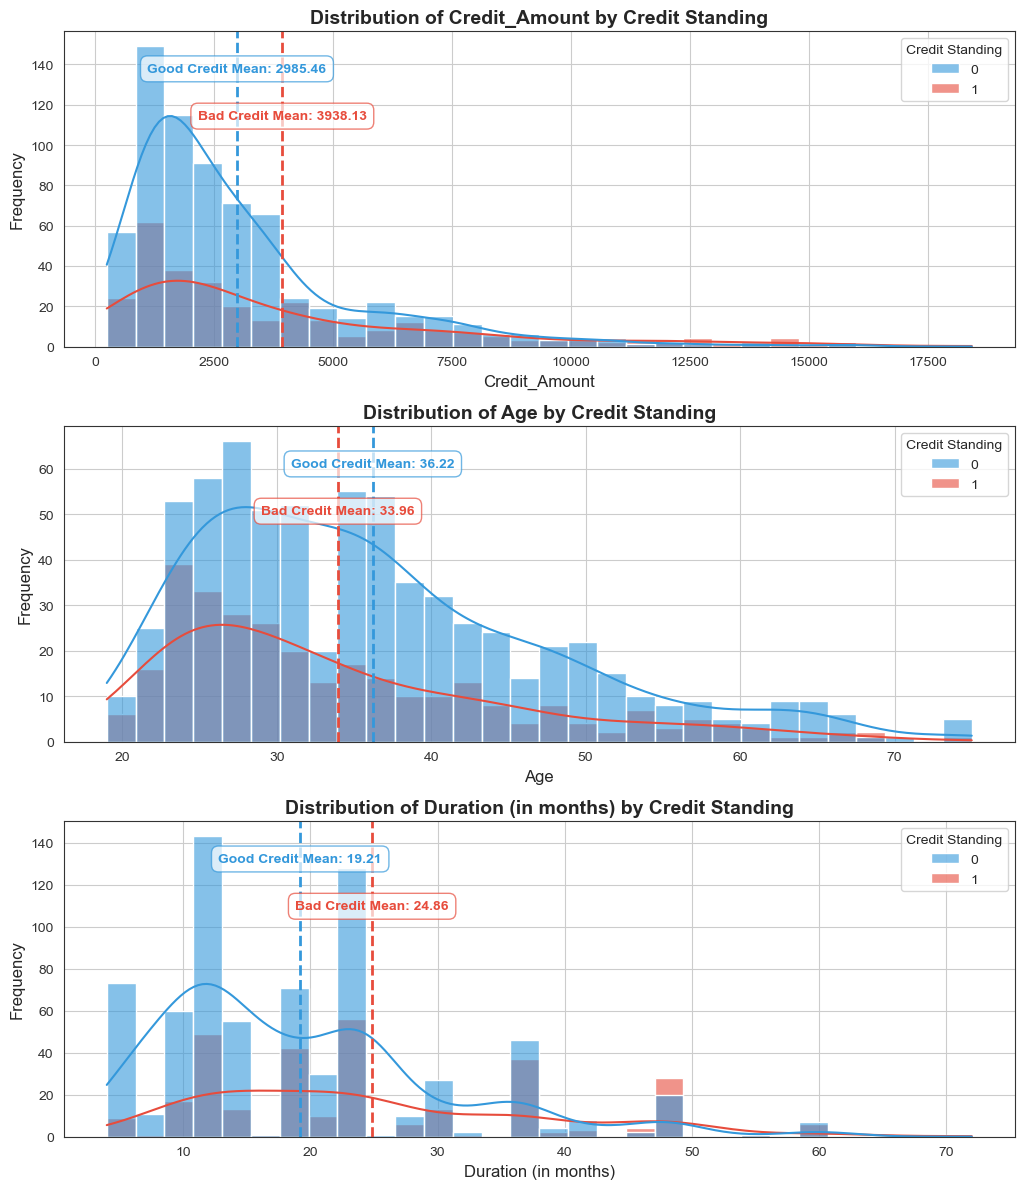

In [8]:
# 3. Feature distributions
# Select top numerical features (based on correlation or importance)
top_features = ['Credit_Amount', 'Age', 'Duration (in months)']

fig, axes = plt.subplots(len(top_features), 1, figsize=(12, 4*len(top_features)))

for i, feature in enumerate(top_features):
    # Create KDE plot with histograms
    # Fix the order of hue levels to ensure correct color mapping
    sns.histplot(data=df, x=feature, hue='Credit Standing', kde=True, 
                 palette=custom_palette, alpha=0.6, bins=30, ax=axes[i],
                 hue_order=[0, 1])  # Explicitly set order: 0=Good, 1=Bad
    
    # Customize the plot
    axes[i].set_title(f'Distribution of {feature} by Credit Standing', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    
   
    # Add mean lines with non-overlapping labels
    for j, (credit_status, color, label) in enumerate(zip([0, 1], custom_palette, ['Good Credit', 'Bad Credit'])):
        subset = df[df['Credit Standing'] == credit_status]
        mean_val = subset[feature].mean()
        count = len(subset)
        percent = 100 * count / len(df)
        
        axes[i].axvline(x=mean_val, color=color, linestyle='--', linewidth=2)
        
        # Position labels at different heights to avoid overlap
        y_pos = axes[i].get_ylim()[1] * (0.9 - j*0.15)  # Stagger vertically
        
        # Add background to text for better readability
        axes[i].text(mean_val, y_pos, 
                     f'{label} Mean: {mean_val:.2f}', 
                     color=color, fontweight='bold', ha='center', va='top',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor=color, boxstyle='round,pad=0.5'))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.show()

In [9]:
# Separate features and target
X = df.drop('Credit Standing', axis=1)
y = df['Credit Standing']

# Create train-test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate and visualize model performance
def evaluate_model(model, X_test, y_test, model_name, scaled=False):
    # Use scaled data if required
    X_test_eval = X_test_scaled if scaled else X_test
    
    # Make predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Print metrics
    print(f"\n{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Good Credit', 'Bad Credit']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Good Credit', 'Bad Credit'],
                yticklabels=['Good Credit', 'Bad Credit'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


Baseline (Majority Class) Performance:
Accuracy: 0.7000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.70      1.00      0.82       175
  Bad Credit       0.00      0.00      0.00        75

    accuracy                           0.70       250
   macro avg       0.35      0.50      0.41       250
weighted avg       0.49      0.70      0.58       250



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

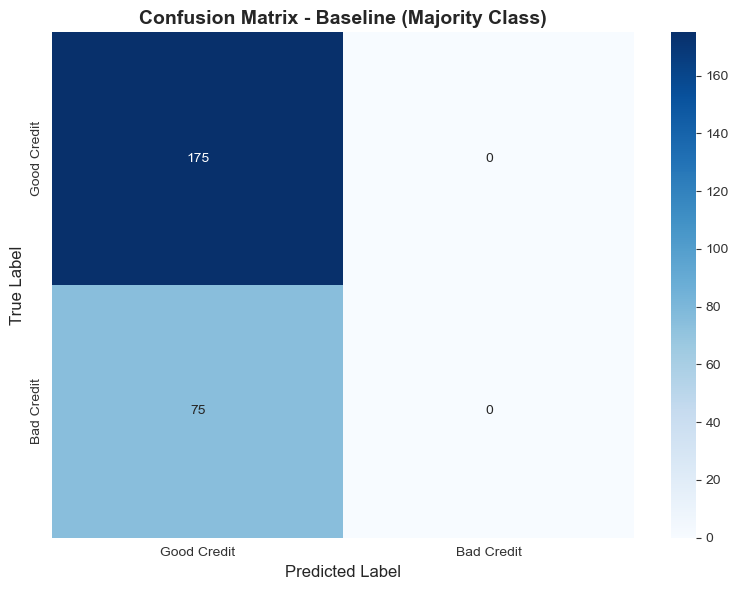

In [10]:
# 1. Baseline Model (Majority Class Classifier)
baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_train, y_train)
baseline_metrics = evaluate_model(baseline_model, X_test, y_test, "Baseline (Majority Class)")


Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

KNN (Optimized) Performance:
Accuracy: 0.7280
Precision: 0.5593
Recall: 0.4400
F1 Score: 0.4925
ROC AUC: 0.7384

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.78      0.85      0.81       175
  Bad Credit       0.56      0.44      0.49        75

    accuracy                           0.73       250
   macro avg       0.67      0.65      0.65       250
weighted avg       0.71      0.73      0.72       250



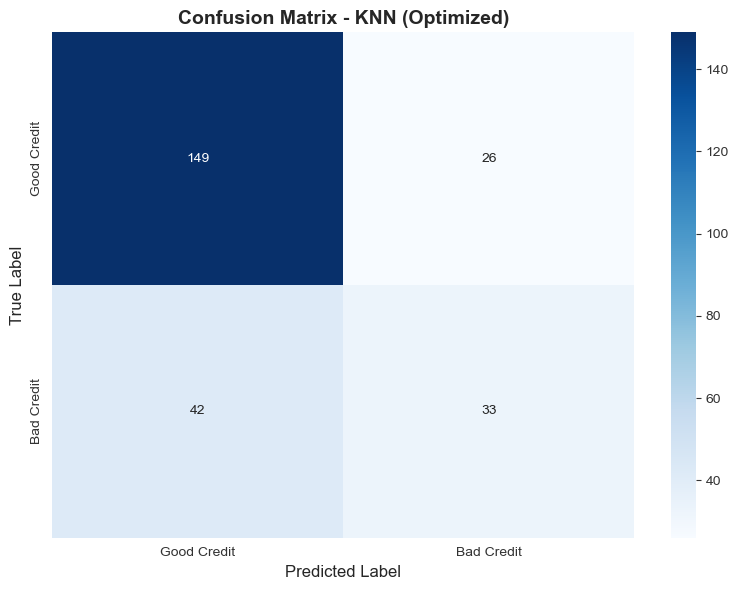

In [11]:
# 2. KNN Classifier with Grid Search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print(f"\nBest KNN parameters: {grid_search.best_params_}")
best_knn = grid_search.best_estimator_
knn_metrics = evaluate_model(best_knn, X_test, y_test, "KNN (Optimized)", scaled=True)




Best Random Forest parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 50}

Random Forest (Optimized) Performance:
Accuracy: 0.7840
Precision: 0.6567
Recall: 0.5867
F1 Score: 0.6197
ROC AUC: 0.7910

Classification Report:
              precision    recall  f1-score   support

 Good Credit       0.83      0.87      0.85       175
  Bad Credit       0.66      0.59      0.62        75

    accuracy                           0.78       250
   macro avg       0.74      0.73      0.73       250
weighted avg       0.78      0.78      0.78       250



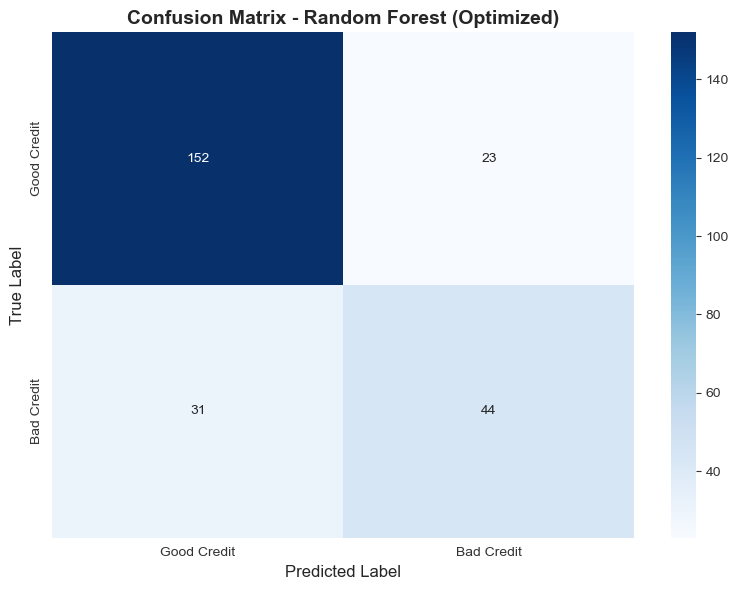

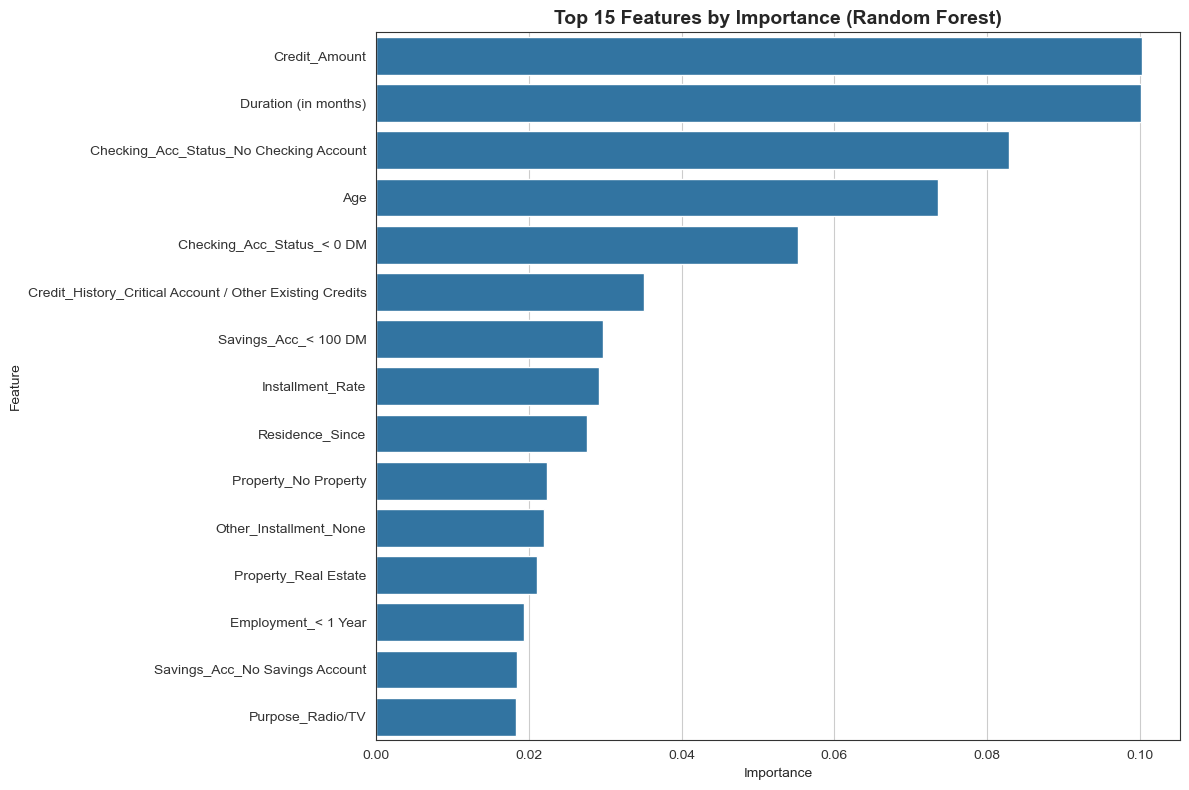

In [12]:
# 3. Random Forest Classifier with Grid Search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
best_rf = grid_search_rf.best_estimator_
rf_metrics = evaluate_model(best_rf, X_test, y_test, "Random Forest (Optimized)")

# Feature importance for Random Forest
if hasattr(best_rf, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title('Top 15 Features by Importance (Random Forest)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()



<Figure size 1200x600 with 0 Axes>

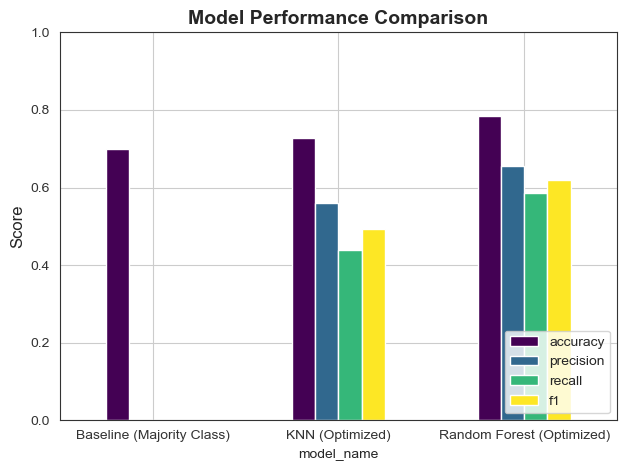

In [13]:
# Compare model performance
models_comparison = pd.DataFrame([baseline_metrics, knn_metrics, rf_metrics])
models_comparison = models_comparison.set_index('model_name')

plt.figure(figsize=(12, 6))
models_comparison[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()